Задание:
1. Модель должна научиться классифицировать текст
2. Должны выполнены три реализации модели. Реализации должны быть основаны на использовании:
    - одномерной сверточной нейросети
    - рекуррентной нейросети LSTM
    - рекуррентной нейросети GRU
3. Выполнить сравнение полученных результатов и сделать вывод

Исходные данные:
- для обучения: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv
- для тестирования: https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv
- имена классов: https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn import functional as F
from transformers import AutoTokenizer

In [2]:
# import os
# from pathlib import Path
# import requests
from utils import check_data_path

In [ ]:
# from tqdm import tqdm
# from sklearn.metrics import f1_score, accuracy_score
# from matplotlib import pyplot as plt
# import torch
from trainer import Trainer

In [ ]:
# import torch
# import torch.nn as nn
from model import TextCNN, TextLSTM, TextGRU

In [3]:
import pandas as pd


# Data check

In [4]:
PATH_TO_DATA = './data'


In [5]:
links = {
    'train.csv': 'https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/train.csv',
    'test.csv': 'https://github.com/mhjabreel/CharCnn_Keras/raw/master/data/ag_news_csv/test.csv',
    'classes.txt': 'https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/classes.txt'
}

In [ ]:
check_data_path(PATH_TO_DATA, links)
# expecting 
# data/train.csv
# data/test.csv
# data/classes.txt

'Ok. All files exist.'

# Data things

In [7]:
df = pd.read_csv(PATH_TO_DATA + '/train.csv', header=None, names=["class", "description", "text"])

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 3 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   class        120000 non-null  int64 
 1   description  120000 non-null  object
 2   text         120000 non-null  object
dtypes: int64(1), object(2)
memory usage: 2.7+ MB


In [9]:
df_test = pd.read_csv(PATH_TO_DATA + '/test.csv', header=None, names=["class", "description", "text"])

In [10]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7600 entries, 0 to 7599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   class        7600 non-null   int64 
 1   description  7600 non-null   object
 2   text         7600 non-null   object
dtypes: int64(1), object(2)
memory usage: 178.3+ KB


In [11]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

In [12]:
tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

In [13]:
# max_length = max(df["text"].apply(lambda x: len(tokenizer.tokenize(str(x)))))
# max_length

In [14]:
from torch.utils.data import Dataset, DataLoader

In [15]:
class NewsDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length):
        """
        Инициализация датасета с предварительной токенизацией.
        
        :param dataframe: pandas.DataFrame, содержащий данные с текстами и метками.
        :param tokenizer: токенизатор (например, Hugging Face Tokenizer).
        :param max_length: максимальная длина токенизированного текста.
        """
        if not {"text", "class"}.issubset(dataframe.columns):
            raise ValueError("DataFrame должен содержать колонки 'text' и 'class'")
        
        self.data = []
        self.max_length = max_length

        for idx, row in dataframe.iterrows():
            text = row["text"]
            label = row["class"]

            # Токенизация текста
            encoded = tokenizer(
                text,
                padding="max_length",
                truncation=True,
                max_length=max_length,
                return_tensors="pt",
            )

            # Вычисление длины текста до паддинга
            input_ids = encoded["input_ids"].squeeze(0)
            attention_mask = encoded["attention_mask"].squeeze(0)
            length = attention_mask.sum().item()  # Сумма единиц в attention_mask

            self.data.append({
                "input_ids": input_ids,
                "attention_mask": attention_mask,
                "length": length,
                "label": torch.tensor(label, dtype=torch.long),
            })

    def __len__(self):
        """
        Возвращает количество элементов в датасете.
        """
        return len(self.data)

    def __getitem__(self, idx):
        """
        Возвращает данные по индексу.
        
        :param idx: индекс элемента.
        :return: словарь с input_ids, attention_mask, длиной текста и меткой.
        """
        return self.data[idx]['input_ids'], self.data[idx]['length'], self.data[idx]['label'] - 1

In [16]:
train_dataset = NewsDataset(dataframe=df, tokenizer=tokenizer, max_length=370)
train_dataloader = DataLoader(train_dataset, batch_size=128, shuffle=True)

In [17]:
test_dataset = NewsDataset(dataframe=df_test, tokenizer=tokenizer, max_length=370)
test_dataloader = DataLoader(test_dataset, batch_size=128, shuffle=True)

# Models

In [41]:
tcnn = TextCNN(vocab_size=tokenizer.vocab_size,
               embed_dim=768, 
               num_classes=4,
               kernel_sizes=[3,4,5], 
               num_filters=32).to(device=DEVICE)


hd = 128
lstm = TextLSTM(vocab_size=tokenizer.vocab_size,
                embed_dim=768,
                hidden_dim=hd,
                num_classes=4
                ).to(DEVICE)

gru = TextGRU(vocab_size=tokenizer.vocab_size,
                embed_dim=768,
                hidden_dim=hd,
                num_classes=4).to(DEVICE)


# Train

In [ ]:
model = lstm

In [ ]:
EPOCHS = 10
learning_rate = 5e-4 # С ветерком перелетим локальные минимумы 😎
# total_steps = len(train_dataloader) * EPOCHS

optimizer = optim.AdamW(model.parameters(), lr=learning_rate, weight_decay=4e-6)
# from adabelief_pytorch import AdaBelief
# optimizer = AdaBelief(lstm.parameters(), lr=learning_rate, eps=learning_rate, betas=(0.9, 0.999), weight_decay=1e-2, weight_decouple=False, rectify=True, print_change_log = False)
criterion = torch.nn.CrossEntropyLoss()
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
# scheduler = optim.lr_scheduler.OneCycleLR(optimizer, max_lr=learning_rate , total_steps=total_steps, pct_start=0.1, anneal_strategy='linear')

In [ ]:
trainer = Trainer(model = model,
                  optimizer = optimizer,
                  criterion = criterion,
                  train_loader = train_dataloader, 
                  val_loader=test_dataloader,
                  device = DEVICE,
                  scheduler = scheduler)
trainer.fit(EPOCHS)

Validating: 100%|██████████| 60/60 [00:00<00:00, 62.91it/s]


Validation Loss: 0.3273, Accuracy: 0.8871, F1 Score: 0.8871
Epoch 1/10 - Train Loss: 0.4566, Val Loss: 0.3273, Acc: 0.8871, F1: 0.8871


Validating: 100%|██████████| 60/60 [00:00<00:00, 62.68it/s]


Validation Loss: 0.3052, Accuracy: 0.8950, F1 Score: 0.8949
Epoch 2/10 - Train Loss: 0.2238, Val Loss: 0.3052, Acc: 0.8950, F1: 0.8949


Validating: 100%|██████████| 60/60 [00:00<00:00, 62.39it/s]


Validation Loss: 0.3220, Accuracy: 0.8968, F1 Score: 0.8969
Epoch 3/10 - Train Loss: 0.1329, Val Loss: 0.3220, Acc: 0.8968, F1: 0.8969


Validating: 100%|██████████| 60/60 [00:00<00:00, 61.47it/s]


Validation Loss: 0.3513, Accuracy: 0.8949, F1 Score: 0.8950
Epoch 4/10 - Train Loss: 0.0719, Val Loss: 0.3513, Acc: 0.8949, F1: 0.8950


Validating: 100%|██████████| 60/60 [00:00<00:00, 63.92it/s]


Validation Loss: 0.3801, Accuracy: 0.8955, F1 Score: 0.8954
Epoch 5/10 - Train Loss: 0.0461, Val Loss: 0.3801, Acc: 0.8955, F1: 0.8954


Training:  59%|█████▊    | 550/938 [00:27<00:19, 20.16it/s]

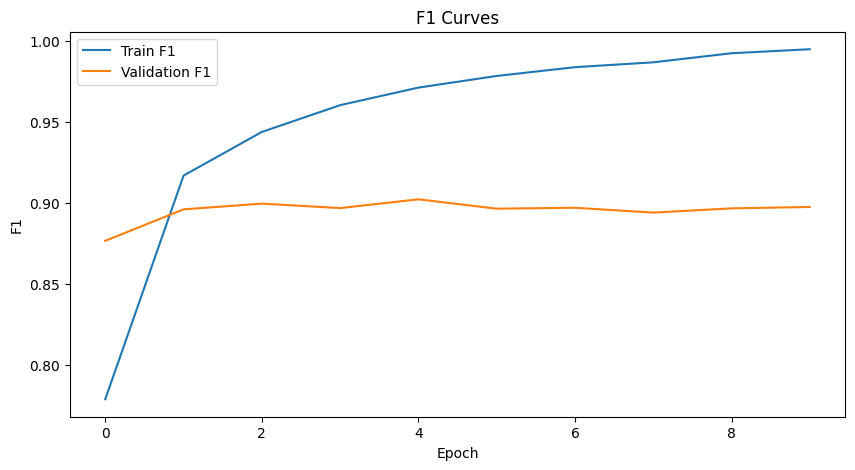

In [38]:
trainer.plot_f1()